In [7]:
# Load the data
import pandas as pd
import json
import matplotlib.pyplot as plt

# Reading the data
data_frame_db1 = pd.DataFrame(pd.read_csv("./data/20230222-alert-data/full-alert-data/alert-data-db1.csv"))
data_frame_db2 = pd.DataFrame(pd.read_csv("./data/20230222-alert-data/full-alert-data/alert-data-db2.csv"))
data_frame_db3 = pd.DataFrame(pd.read_csv("./data/20230222-alert-data/full-alert-data/alert-data-db3.csv"))

# Creating main dataframe
data_frame = pd.concat([data_frame_db1, data_frame_db2, data_frame_db3], sort=False)
data_frame.reset_index()

# Deconstructing the sources data
# to create one source per row
sources_df = pd.DataFrame({'AlertKey':[],
                           'Source': [],
                           'Url':[]})

data_frame = data_frame[data_frame["DiscoveryDate"] > "2021-12-31"]

for index, row in data_frame.iterrows():
    json_sources = row['Sources']
    sources = json.loads(json_sources)
    for key in sources.keys():
        # Dropping entries for TWC
        if key != "TwC":
            sources_df = pd.concat([sources_df, pd.DataFrame({'AlertKey': row['AlertKey'], 'Source': key, 'Url': sources[key]})])

data_frame = data_frame.merge(sources_df, left_on='AlertKey', right_on='AlertKey')
data_frame.drop('Sources', axis=1, inplace=True)

# Adding component type information
component_type_data = [[1, "NuGet"], [2, "Npm"], [3, "Maven"], [4, "Git"], [6, "RubyGems"], [7, "Cargo"], [8, "Pip"], [9, "File"], [10, "Go"], [12, "Pod"], [13, "Linux"], [14, "Conda"]]
component_typesDf = pd.DataFrame(data=component_type_data, columns=["ComponentTypeId", "ComponentType"])
data_frame = data_frame.merge(right=component_typesDf, left_on="ComponentType", right_on="ComponentTypeId", how="left")
data_frame.drop('ComponentTypeId', axis=1, inplace=True)
data_frame.drop('ComponentType_x', axis=1, inplace=True)
data_frame.rename(columns={'ComponentType_y': 'ComponentType'}, inplace=True)

# Adding severity information
severity_data = [[0, "Low"], [1, "Medium"], [2, "High"], [3, "Critical"]]
severities = pd.DataFrame(data=severity_data, columns=["SeverityId", "Severity"])
data_frame = data_frame.merge(right=severities, left_on="Severity", right_on="SeverityId", how="left")
data_frame.drop('SeverityId', axis=1, inplace=True)
data_frame.drop('Severity_x', axis=1, inplace=True)
data_frame.rename(columns={'Severity_y': 'Severity'}, inplace=True)

# Filtering Data
last_year_data = data_frame[data_frame["DiscoveryDate"] > "2021-12-31"]
#

KeyboardInterrupt: 

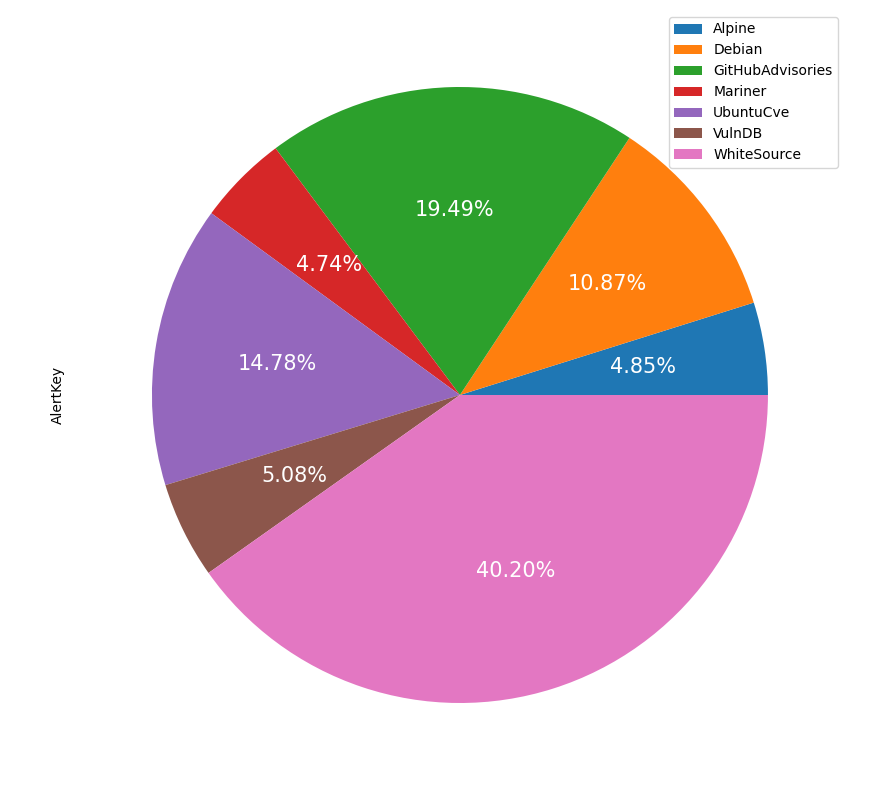

In [138]:
# Alerts distribution by data providers

last_year_data.groupby('Source')['AlertKey'] \
    .count() \
    .plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10), autopct='%1.2f%%', legend=True)

plt.show()

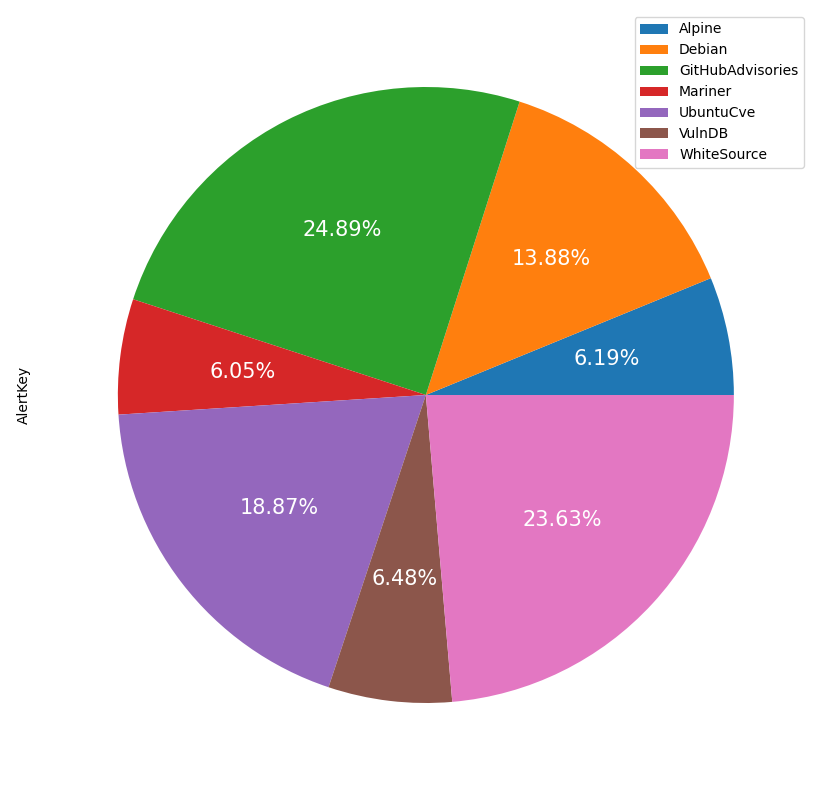

In [61]:

# Alerts distribution by data providers excluding ComponentType File
last_year_data[last_year_data['ComponentType'] != "File"].groupby('Source')['AlertKey']\
    .count()\
    .plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10), autopct='%1.2f%%', legend=True)

plt.show()


In [154]:
# Percentage of alerts that are only found in GA
ga_alerts = last_year_data[last_year_data['Source'] == 'GitHubAdvisories']
no_ga_alerts = last_year_data[last_year_data['Source'] != 'GitHubAdvisories']
# some alerts are found in multiple sources, doing this we guarantee that we are going to get
# only the alerts that have only one source and that source is GithubAdvisories
only_ga = ga_alerts[~ga_alerts['AlertKey'].isin(no_ga_alerts['AlertKey'])]
(only_ga.shape[0]/data_frame.shape[0])*100

5.779678649867067

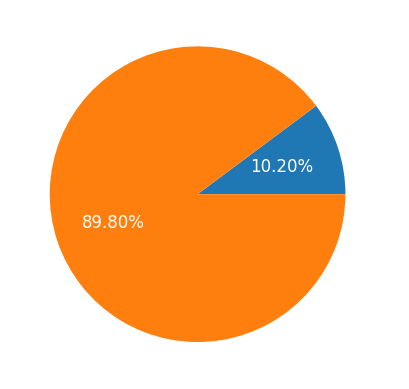

In [165]:
# Distribution of vulnerabilities ids from alerts found only by GA

ghsa = only_ga.Title.str.startswith('GHSA', na=False).sum()
cve = only_ga.Title.str.startswith('CVE', na=False).sum()

plt.pie([ghsa, cve], labels=["GHSA", "CVE" ], textprops={'color':"white", 'fontsize':12}, autopct='%1.2f%%' )
plt.show()

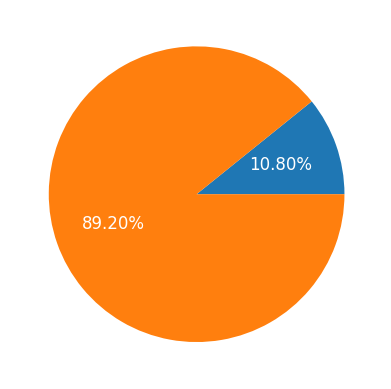

In [156]:
# Distribution of vulnerabilities ids for alerts that were only found by WS
ws_alerts = last_year_data[last_year_data['Source'] == 'WhiteSource']
no_ws_alerts = last_year_data[last_year_data['Source'] != 'WhiteSource']
only_ws = ws_alerts[~ws_alerts['AlertKey'].isin(no_ws_alerts['AlertKey'])]

ws = only_ws.Title.str.startswith('WS', na=False).sum()
cve = only_ws.Title.str.startswith('CVE', na=False).sum()

plt.pie([ws, cve], labels=["WS", "CVE"], textprops={'color':"white", 'fontsize':12}, autopct='%1.2f%%')
plt.show()

In [158]:

ws_cve_alerts = ws_alerts[ws_alerts.Title.str.startswith('CVE', na=False)]
gha_cve_alerts = ga_alerts[ga_alerts['Title'].str.startswith('CVE', na=False)]
only_ws_cve = only_ws[only_ws.Title.str.startswith('CVE', na=False)]
only_gha_cve = only_ga[only_ga.Title.str.startswith('CVE', na=False)]


<AxesSubplot: ylabel='AlertKey'>

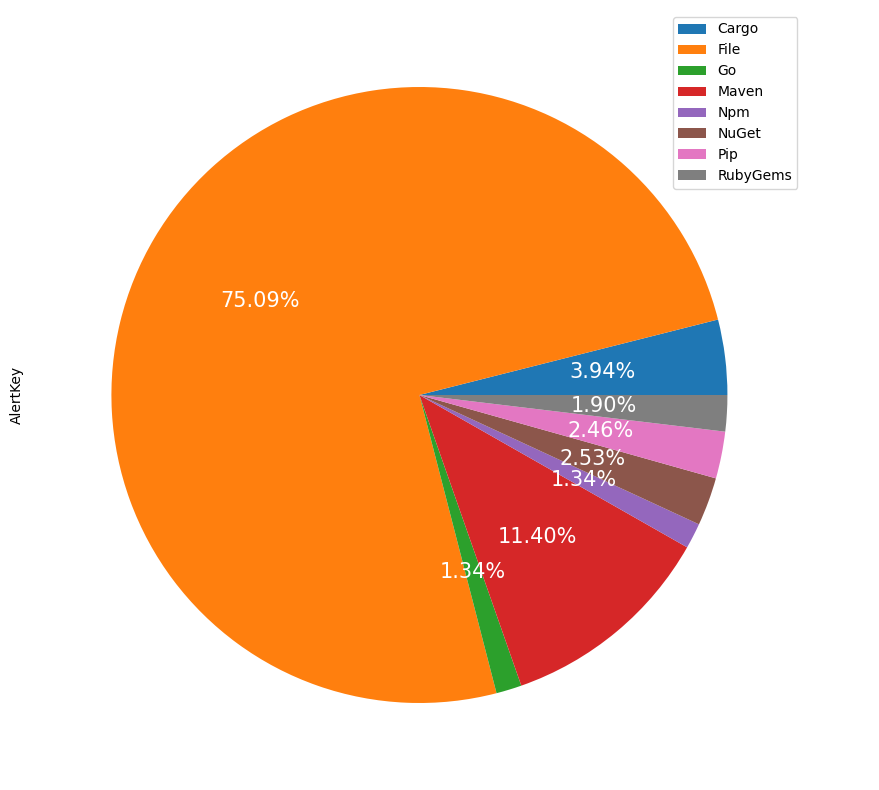

In [159]:
# Component types of the CVE alerts that where only found by WS
only_ws_cve.groupby('ComponentType')['AlertKey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10),autopct='%1.2f%%', legend=True)

<AxesSubplot: ylabel='AlertKey'>

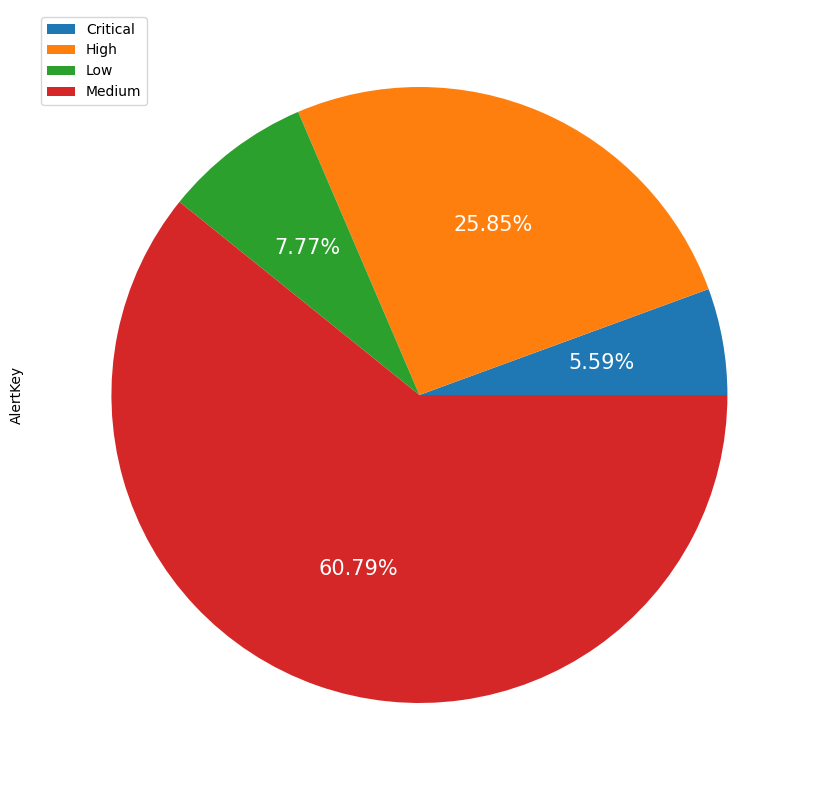

In [148]:
# Severity distribution of alerts of type File
last_year_data[last_year_data["ComponentType"] == "File"].groupby("Severity")["AlertKey"].count().plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10),autopct='%1.2f%%', legend=True)


In [160]:
# percentage of whitesource alerts that are also found in github advisories for common component types.
ws_common = ws_cve_alerts[(ws_cve_alerts["ComponentType"] == "Npm") | (ws_cve_alerts["ComponentType"] == "RubyGems") | (ws_cve_alerts["ComponentType"] == "Maven") | (ws_cve_alerts["ComponentType"] == "NuGet")]
ws_alerts_covered_by_ga = gha_cve_alerts[gha_cve_alerts["AlertKey"].isin(ws_common['AlertKey'])]
(ws_alerts_covered_by_ga.shape[0]/ws_common.shape[0]) * 100

62.51920122887865

<AxesSubplot: ylabel='AlertKey'>

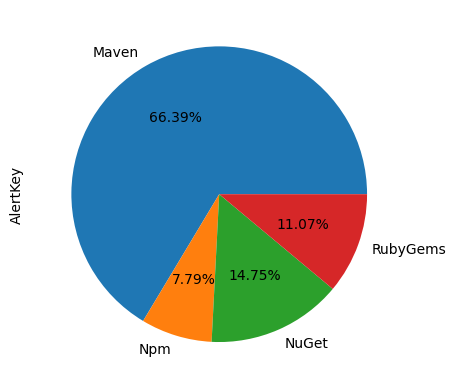

In [162]:
# Distribution of CVE alerts only found by WS in commons component types.
common_type_ws_only_alerts = ws_common[(~(ws_common["AlertKey"].isin(ws_alerts_covered_by_ga['AlertKey'])))]
common_type_ws_only_alerts .groupby("ComponentType")["AlertKey"].count().plot(kind="pie", autopct='%1.2f%%')

In [123]:
common_type_ws_only_alerts[common_type_ws_only_alerts["ComponentType"] == "Maven"]

,PartitionId,DataspaceId,RepositoryId,AlertId,Description,Title,AlertKey,DiscoveryDate,Source,Url,ComponentType,Severity
56,10,1814,154950,7476542,JacksonJsonpInterceptor in RESTEasy might allo...,CVE-2016-6348,v6:499f6f3a077e44a7aee44ed69d3ba637,2022-07-22 00:14:25.3276444,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Maven,Medium
178,10,2133,185250,6802034,"By default, Apache CXF creates a /services pag...",CVE-2019-17573,v6:86ec0a83cdad450ba825758305851be6,2022-03-21 10:23:28.4417115,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Maven,Medium
186,10,1814,3233,6841068,randomUUID in Scala.js before 1.10.0 generates...,CVE-2022-28355,v6:75379330e7ea4e4a9f2bd6bff5d64ce6,2022-04-04 20:23:02.2537533,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Maven,Medium
201,10,1814,104410,7351077,A mis-handling of invalid unicode characters i...,CVE-2020-8929,v6:4365ce980e8749d08015002d39201d90,2022-06-27 08:22:54.9749161,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Maven,Medium
492,10,2133,198059,7533848,A vulnerability in Apache Flink (1.1.0 to 1.1....,CVE-2020-1960,v6:834dcaaafe0d4de9b2a3fe04debe1e3c,2022-08-03 12:52:43.6632759,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Maven,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
8604,3,167420,193662,6809247,TensorFlow is an end-to-end open source platfo...,CVE-2021-37688,v6:bca607f7a9184d9d830d9c0e921d56df,2022-03-23 21:09:57.0369425,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Maven,Low
8605,3,167420,193662,6809249,TensorFlow is an end-to-end open source platfo...,CVE-2021-37681,v6:ed3d863a8449441cae17803f32594685,2022-03-23 21:09:57.0369425,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Maven,Medium
8606,3,167420,193662,6809241,TensorFlow is an end-to-end open source platfo...,CVE-2021-37682,v6:0463e1c29a01467580e0135ea6482470,2022-03-23 21:09:57.0369425,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Maven,Low
8607,3,167420,193662,6809242,TensorFlow is an end-to-end open source platfo...,CVE-2021-37687,v6:3470d2d9cc31459f811943a4c079ed35,2022-03-23 21:09:57.0369425,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Maven,Low


<AxesSubplot: ylabel='AlertKey'>

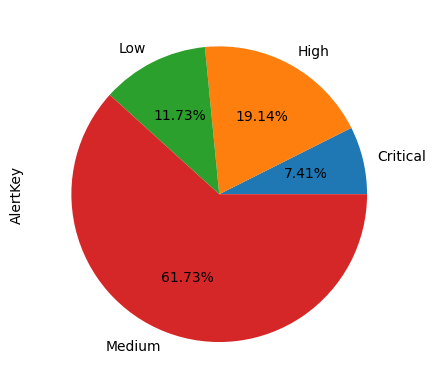

In [124]:
common_type_ws_only_alerts[common_type_ws_only_alerts["ComponentType"] == "Maven"].groupby("Severity")["AlertKey"].count().plot(kind="pie", autopct='%1.2f%%')

In [141]:
common_type_ws_only_alerts[common_type_ws_only_alerts["ComponentType"] == "Npm"]

,PartitionId,DataspaceId,RepositoryId,AlertId,Description,Title,AlertKey,DiscoveryDate,Source,Url,ComponentType,Severity
42,10,1814,106763,6694405,jQuery Cookie 1.4.1 is affected by prototype p...,CVE-2022-23395,v6:63c60f7d750b43188b2ddcd6070b8cc4,2022-03-03 22:17:15.2251341,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Npm,Medium
2506,220,6325,120703,8096127,The package snyk before 1.1064.0 are vulnerabl...,CVE-2022-24441,v6:dcfb0c79d2a5401b92af3b5840971117,2022-12-02 10:22:33.0590284,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Npm,High
2575,205,34348,154455,8258949,All versions of the package create-choo-electr...,CVE-2022-25908,v6:9192c8375c094a46bd58c7ffd66c86dc,2023-01-27 20:31:05.0428269,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Npm,Critical
2739,430,7052,89016,7202661,An arbitrary file upload vulnerability in the ...,CVE-2022-29623,v6:cd045fb1b7e04cae9d70fa4a788ac441,2022-05-17 20:39:33.9418167,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Npm,Medium
2973,933,8510,195434,7350853,A Regular Expression Denial of Service (ReDOS)...,CVE-2021-40892,v6:a762755cbb5b4217a15d6c74f44f05c6,2022-06-27 07:21:11.8559827,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Npm,Medium
3376,2767,50640,178193,7410482,Underscore.deep is a collection of Underscore ...,CVE-2022-31106,v6:4e5dfc6d28a04e329b10c3afc982c1ff,2022-07-01 07:30:46.0224729,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Npm,High
3522,3019,159651,189358,8352888,** DISPUTED ** CKSource CKEditor 5 35.4.0 was ...,CVE-2022-48110,v6:cbf058f1d427411790634181c59eb192,2023-02-21 05:14:15.6199776,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Npm,Medium
3671,3344,139174,160777,7892656,Prototype pollution vulnerability in beautify-...,CVE-2022-37609,v6:5d44c13cb1784cd999d31bc8e4fa5adc,2022-10-28 19:49:27.9371124,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Npm,Critical
5696,36366,141891,182977,7193102,OpenZeppelin Contracts is a library for smart ...,CVE-2022-31172,v6:7ea84b5b4dec443cb70fb2e5f9b4cd61,2022-07-22 19:44:48.3491440,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Npm,High
5718,36366,136532,162693,6752698,This affects the package node-ipc from 10.1.1 ...,CVE-2022-23812,v6:ff8802ce13184ad4ab8b73eaaba1b4f8,2022-03-17 16:12:55.8030365,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,Npm,Critical


<AxesSubplot: ylabel='AlertKey'>

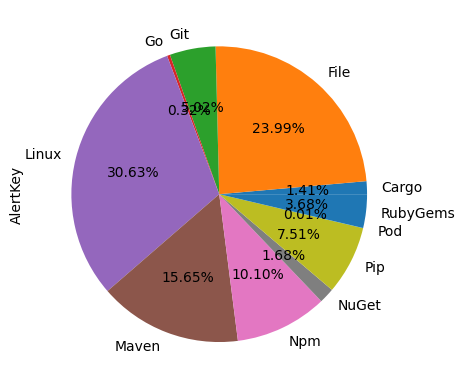

In [167]:
data_frame.groupby('ComponentType')['AlertKey'].count().plot(kind="pie", autopct='%1.2f%%')

In [ ]:
# Data qu